In [16]:
###Import
import sys
from cycler import cycler

#import geobayes_simple as gs
from matplotlib import pyplot as plt
from IPython.core.display import Image

%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from IPython.core.pylabtools import figsize
figsize(10, 3)
import seaborn
seaborn.set_context(font_scale=2)
seaborn.set_style("white")

from pymc import graph

import scipy.optimize as sop
import scipy.stats as stats
import matplotlib.mlab as mlab

In [17]:
#Weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

estimates_s = np.arange(-1000,1000,1)

In [18]:
res_score = np.random.normal(0, 500, 100000)

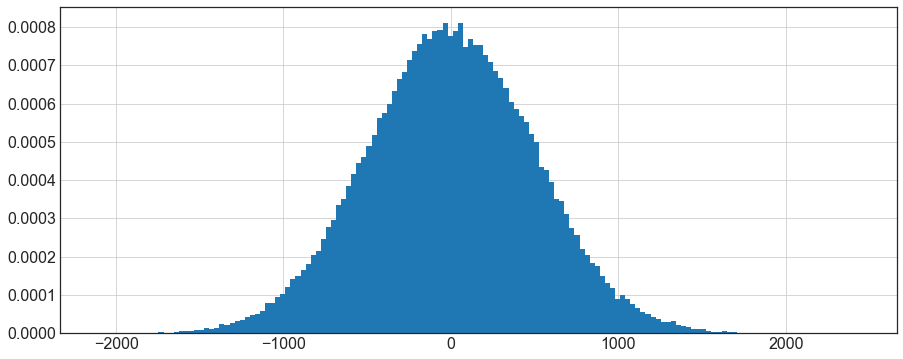

In [19]:
figsize(15, 6)

_hist = plt.hist(res_score, bins=150, normed=True, histtype="stepfilled")
plt.grid()

In [20]:
#II - Variations of asymmetric absolute loss function

#IIa - Standard absolute-error loss function
def res_score_loss1(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s)
        overest = (estimate_s > true_s) 
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
#IIb - Adaption: Overestimation worse than underestimation (by factor ov)
def res_score_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        overest = (estimate_s > true_s) 
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        return loss_s    
    
#IIc - Adaption: Introducing worst-case/fatal overestimation
def res_score_loss3(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s
    
#IId - Adaption: Introducing worst-case/fatal underestimation
def res_score_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s
    
#IId.2 - Version for given values
def res_score_lossG(estimate_s, true_s):
        if estimate_s < true_s:
            if estimate_s <= 0 and true_s > 0:
                loss_s = (true_s - estimate_s)*(uv_b) #bad case of underestimation
            else:
                loss_s = (true_s - estimate_s) #normal underestimation
        elif estimate_s > true_s:
            if estimate_s > 0 and true_s <= 0:
                loss_s = (estimate_s - true_s)*(ov_b) #bad case of overestimation
            else:
                loss_s = (estimate_s - true_s)*(ov) #normal overestimation
        else:
            loss_s = 0
        return loss_s

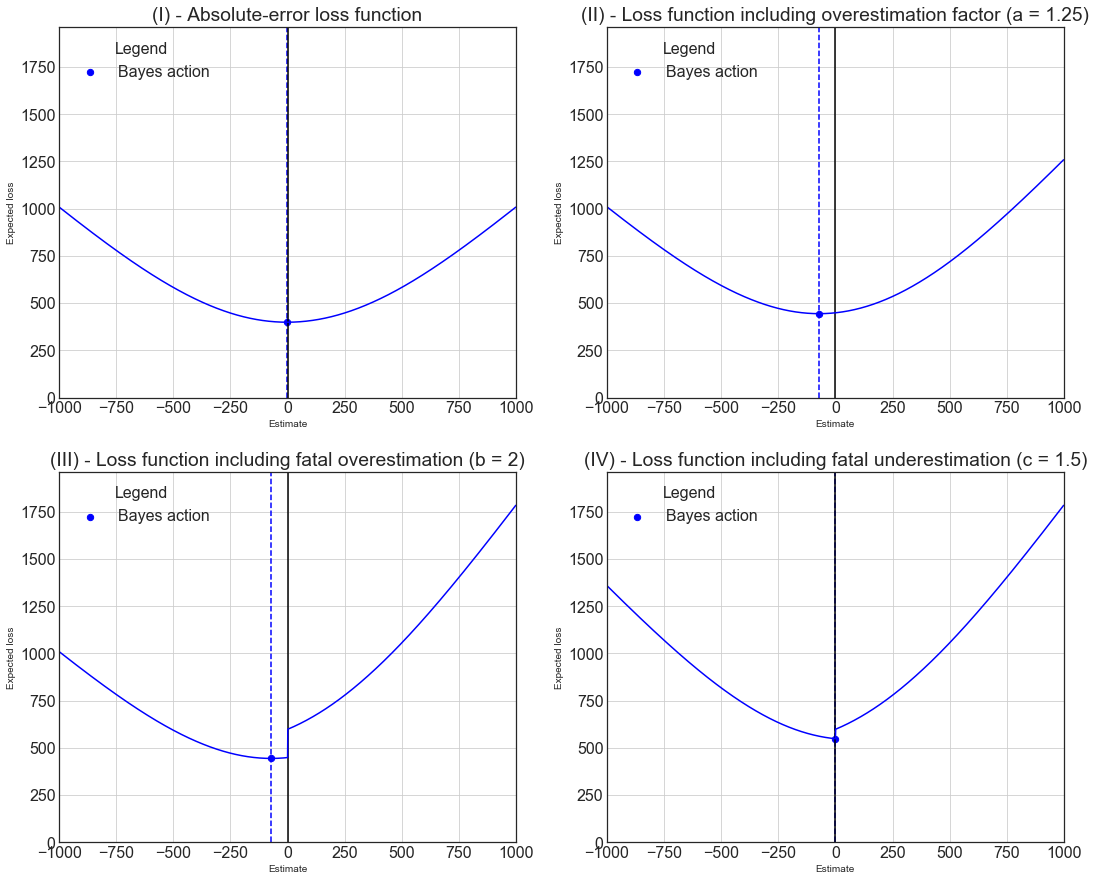

In [21]:
figsize(18, 15)
fig, ax = plt.subplots(2, 2, sharey=False)

plt.rcParams.update({'font.size': 16})
#IIa
expected_loss_sIIa = lambda estimate_s: res_score_loss1(estimate_s, res_score).mean()
loss = [expected_loss_sIIa(e) for e in estimates_s]
_min_loss1 = sop.fmin(expected_loss_sIIa, -40, disp = False)
ax[0,0].plot(estimates_s, loss, color = 'blue')
ax[0,0].vlines(_min_loss1, 0, 20000, color='blue', linestyles="--")
ax[0,0].scatter(_min_loss1, expected_loss_sIIa(_min_loss1), s = 40, color = 'blue', label = "Bayes action")


#IIb
expected_loss_sIIb = lambda estimate_s: res_score_loss2(estimate_s, res_score).mean()
loss = [expected_loss_sIIb(e) for e in estimates_s]
_min_loss2 = sop.fmin(expected_loss_sIIb, -40, disp = False)
ax[0,1].plot(estimates_s, loss, color = 'blue')
ax[0,1].vlines(_min_loss2, 0, 20000, color='blue', linestyles="--")
ax[0,1].scatter(_min_loss2, expected_loss_sIIb(_min_loss2), s = 40, color = 'blue', label = "Bayes action")

#IIc
expected_loss_sIIc = lambda estimate_s: res_score_loss3(estimate_s, res_score).mean()
loss = [expected_loss_sIIc(e) for e in estimates_s]
_min_loss3 = sop.fmin(expected_loss_sIIc, -40, disp = False)
ax[1,0].plot(estimates_s, loss, color = 'blue')
ax[1,0].vlines(_min_loss3, 0, 20000, color='blue', linestyles="--")
ax[1,0].scatter(_min_loss3, expected_loss_sIIc(_min_loss3), s = 40, color = 'blue', label = "Bayes action")

#IId
expected_loss_sIId = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()
loss = [expected_loss_sIId(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_sIId, -40, disp = False)
ax[1,1].plot(estimates_s, loss, color = 'blue')
ax[1,1].vlines(_min_loss4, 0, 20000, color='blue', linestyles="--")
ax[1,1].scatter(_min_loss4, expected_loss_sIId(_min_loss4), s = 40, color = 'blue', label = "Bayes action")

#IIa layout
ax[0,0].set_title("""(I) - Absolute-error loss function""")    
ax[0,0].set_xlabel("Estimate")
ax[0,0].set_ylabel("Expected loss")
ax[0,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,0].set_ylim(0,1.1 * np.max(loss))
ax[0,0].grid()
ax[0,0].vlines(0, 0, 1.1 * np.max(loss), linestyles="-")
#ax[0,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
#ax[0,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,0].legend(loc="upper left", scatterpoints=1, title="Legend");

#IIb layout
ax[0,1].set_title("""(II) - Loss function including overestimation factor (a = 1.25)""")    
ax[0,1].set_xlabel("Estimate")
ax[0,1].set_ylabel("Expected loss")
ax[0,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,1].set_ylim(0,1.1 * np.max(loss))
ax[0,1].grid()
ax[0,1].vlines(0, 0, 1.1 * np.max(loss), linestyles="-")
#ax[0,1].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
#ax[0,1].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,1].legend(loc="upper left", scatterpoints=1, title="Legend");

#IIc layout
ax[1,0].set_title("""(III) - Loss function including fatal overestimation (b = 2)""")    
ax[1,0].set_xlabel("Estimate")
ax[1,0].set_ylabel("Expected loss")
ax[1,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,0].set_ylim(0,1.1 * np.max(loss))
ax[1,0].grid()
ax[1,0].vlines(0, 0, 1.1 * np.max(loss), linestyles="-")
#ax[1,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
#ax[1,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,0].legend(loc="upper left", scatterpoints=1, title="Legend");

#IId layout
ax[1,1].set_title("""(IV) - Loss function including fatal underestimation (c = 1.5)""")    
ax[1,1].set_xlabel("Estimate")
ax[1,1].set_ylabel("Expected loss")
ax[1,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,1].set_ylim(0,1.1 * np.max(loss))
ax[1,1].grid()
ax[1,1].vlines(0, 0, 1.1 * np.max(loss), linestyles="-")
#plt.vlines(_min_score, 0, 20000, color=_color['color'], linestyles="--")
#ax[1,1].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
#ax[1,1].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":");
ax[1,1].legend(loc="upper left", scatterpoints=1, title="Legend");

In [22]:
given_score1 = -250
given_score2 = 0
given_score3 = 250

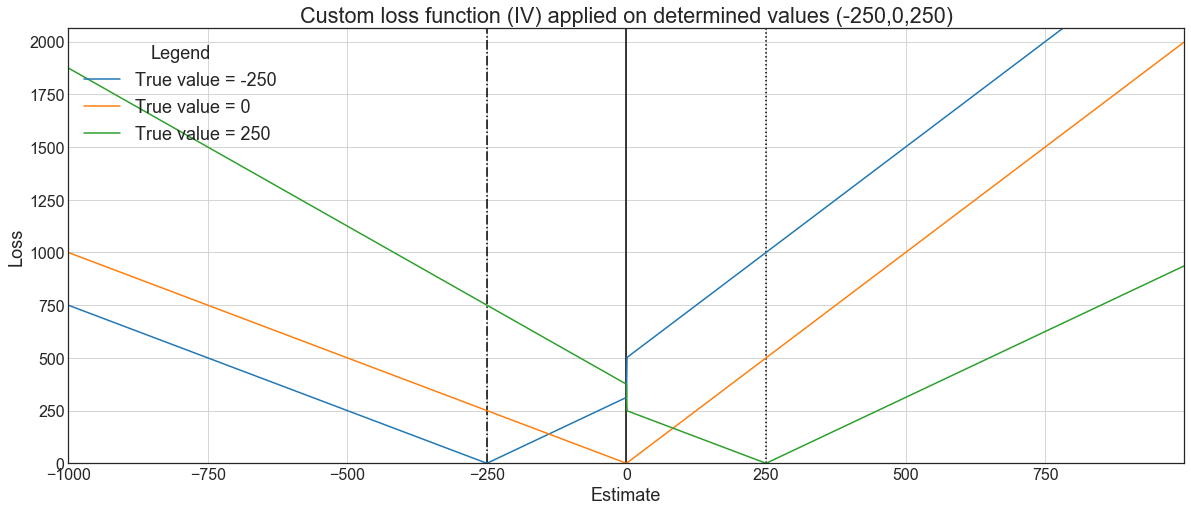

In [23]:
#plt.rc('xtick', labelsize=15) 
#plt.rc('ytick', labelsize=15) 
figsize(20, 8)
plt.rcParams.update({'font.size': 18})

expected_loss_sG1 = lambda estimate_s: res_score_lossG(estimate_s, given_score1)
expected_loss_sG2 = lambda estimate_s: res_score_lossG(estimate_s, given_score2)
expected_loss_sG3 = lambda estimate_s: res_score_lossG(estimate_s, given_score3)

figsize(20, 8)

loss = [expected_loss_sG1(e) for e in estimates_s]
plt.plot(estimates_s, loss, label="True value = %d" % (given_score1), linewidth = 1.5) #color="maroon")

loss = [expected_loss_sG2(e) for e in estimates_s]
plt.plot(estimates_s, loss, label="True value = %d" % (given_score2), linewidth = 1.5)# color="steelblue")

loss = [expected_loss_sG3(e) for e in estimates_s]
plt.plot(estimates_s, loss,label="True value = %d" % (given_score3), linewidth = 1.5)# color="g")

plt.grid()
plt.vlines(given_score1, 0, 1.1 * np.max(loss), linestyles="-.")
plt.vlines(given_score2, 0, 1.1 * np.max(loss), linestyles="-")
plt.vlines(given_score3, 0, 1.1 * np.max(loss), linestyles=":")
#plt.vlines(given_score1, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score1), linestyles="-.")
#plt.vlines(given_score2, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score2), linestyles="-")
#plt.vlines(given_score3, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score3), linestyles=":")
plt.xlabel("Estimate")
plt.ylabel("Loss")
plt.title("Custom loss function (IV) applied on determined values (-250,0,250)")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss));
plt.legend(loc="upper left", title="Legend");

In [24]:
risks_s = np.arange(0.5, 1.6, 0.25)

In [25]:
#IIIa - Risk as a parameter influencing the weighting
def res_score_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)*(risk_s**-0.5)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return loss_s
    
def res_score_lossGR(estimate_s, true_s, risk_s):
        if estimate_s < true_s:
            if estimate_s <= 0 and true_s > 0:
                loss_s = (true_s - estimate_s)*(uv_b*(risk_s**-0.5)) #bad case of underestimation
            #elif estimate_s < true_s and true_s <= 0: #"good"/irrelevant underestimation
            #    loss_s = 0
            else:
                loss_s = (true_s - estimate_s) #normal underestimation
        elif estimate_s > true_s:
            if estimate_s > 0 and true_s <= 0:
                loss_s = (estimate_s - true_s)*(ov_b*risk_s) #bad case of overestimation
            #elif estimate_s > true_s and estimate_s <= 0: #"good"/irrelevant overestimation
            #    loss_s = 0
            else:
                loss_s = (estimate_s - true_s)*(ov*risk_s) #normal overestimation
        else:
            loss_s = 0
        return loss_s
    
#IIIb - Risk as a max. loss
def res_score_lossR2(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*((ov*(risk_s/risks_s2[2])))
        loss_s[overest_bad] = risk_s
        return loss_s

Bayes action (minimum) at risk r 0.50: 128.18 --- expected loss: 468.49
Bayes action (minimum) at risk r 0.75: 0.00 --- expected loss: 529.40
Bayes action (minimum) at risk r 1.00: 0.00 --- expected loss: 548.40
Bayes action (minimum) at risk r 1.25: -58.71 --- expected loss: 575.76
Bayes action (minimum) at risk r 1.50: -155.51 --- expected loss: 592.66


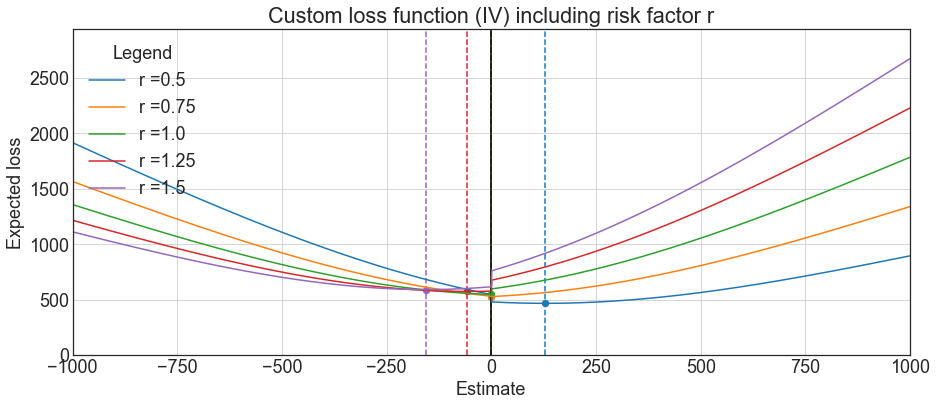

In [26]:
figsize(15, 6)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.rcParams.update({'font.size': 18})
ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 40, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_score, 0, 20000, color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_score,\
                                                                              expected_loss_s(_min_score,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

In [27]:
def abs_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
def abs_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])
        return loss_s

#Symmetric absolute loss for one given value
def simple_abs_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)
        return loss_s
    
#Ib - Symmetric squared loss function
def sqr_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)**2
        loss_s[overest] = (estimate_s - true_s[overest])**2
        return loss_s
    
def sqr_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])**2
        return loss_s
    
#Symmetric squared loss for one given value
def simple_sqr_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)**2
        return loss_s

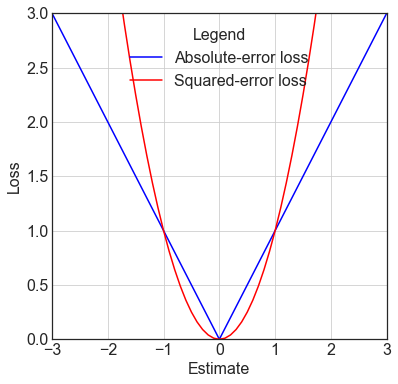

In [28]:
figsize(20,15)
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
given_score1=-750
given_score2=0
given_score3=750

expected_absloss_s1 = lambda estimate_s: simple_abs_loss(estimate_s, given_score1)
expected_absloss_s2 = lambda estimate_s: simple_abs_loss(estimate_s, given_score2)
expected_absloss_s3 = lambda estimate_s: simple_abs_loss(estimate_s, given_score3)

expected_sqrloss_s1 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score1)
expected_sqrloss_s2 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score2)
expected_sqrloss_s3 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score3)

estimates_g = np.arange(-1000,1000,0.1)
figsize(6,6)
#fig, ax = plt.subplots(1)
plt.grid()
plt.xlim(-3,3)
plt.ylim(0,3)
plt.xlabel("Estimate")
plt.ylabel("Loss")
#plt.title("Absolute- and squared-error loss functions given true value = 0")

absloss = [expected_absloss_s2(e) for e in estimates_g]
plt.plot(estimates_g, absloss, color = 'blue', label='Absolute-error loss')

sqrloss = [expected_sqrloss_s2(e) for e in estimates_g]
plt.plot(estimates_g, sqrloss, color = 'red', label='Squared-error loss')

plt.legend(loc="upper center", scatterpoints=1, title="Legend");

Bayes action (min. expected loss) using absolute loss: -1.78
Bayes action (min. expected loss) using squared loss: -0.02


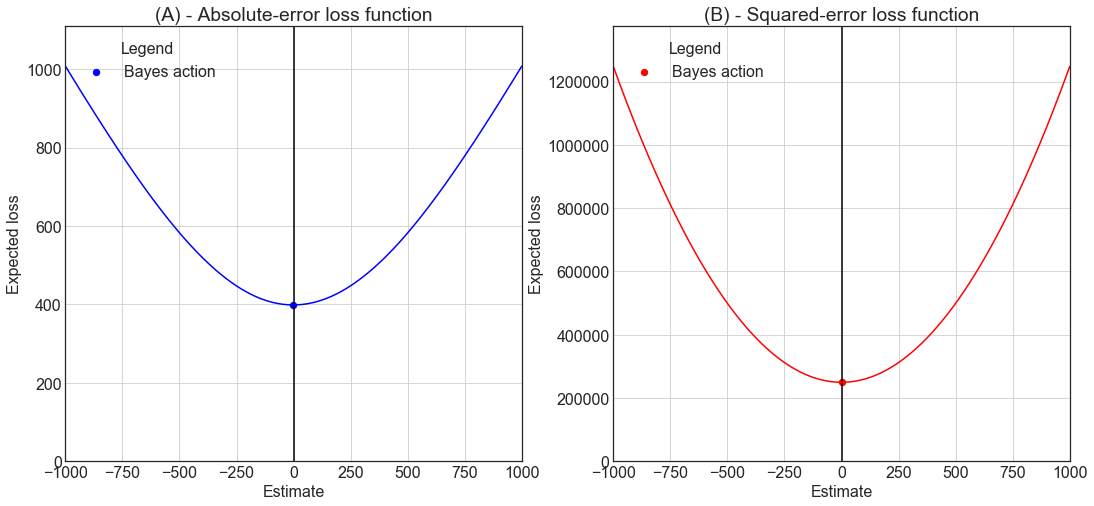

In [29]:
figsize(18, 8)
fig, ax = plt.subplots(1, 2)

#Expected absolute loss
expected_abs_loss = lambda estimate_s: simple_abs_loss(estimate_s, res_score).mean()
absloss = [expected_abs_loss(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'blue')
_min_absloss = sop.fmin(expected_abs_loss, 40,disp = False)
ax[0].scatter(_min_absloss, np.min(absloss), s = 40, color = 'blue', label = "Bayes action")
print("Bayes action (min. expected loss) using absolute loss: %.2f" % (_min_absloss))

ax[0].grid()
ax[0].vlines(0, 0, 1.1 * np.max(absloss), linestyles="-")
#ax[0].vlines(res_score.mean(), 0, 1.1 * np.max(absloss), label="score mean", linestyles="-.")
#ax[0].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(absloss), label="score median", linestyles=":")
ax[0].set_xlabel("Estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_title("(A) - Absolute-error loss function")
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(absloss))

#Expected squared loss
expected_sqr_loss = lambda estimate_s: sqr_loss(estimate_s, res_score).mean()
sqrloss = [expected_sqr_loss(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'red')
_min_sqrloss = sop.fmin(expected_sqr_loss, 40,disp = False)
ax[1].scatter(_min_sqrloss, np.min(sqrloss), s = 40, color = 'red', label = "Bayes action")
print("Bayes action (min. expected loss) using squared loss: %.2f" % (_min_sqrloss))
ax[1].hist(res_score, bins=150, normed=True, histtype="stepfilled")

ax[1].grid()
ax[1].vlines(0, 0, 1.1 * np.max(sqrloss), linestyles="-")
#ax[1].vlines(res_score.mean(), 0, 1.1 * np.max(sqrloss), label="score mean", linestyles="-.")
#ax[1].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(sqrloss), label="score median", linestyles=":")
ax[1].set_xlabel("Estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_title("(B) - Squared-error loss function")
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(sqrloss))

ax[0].legend(loc="upper left", scatterpoints=1, title="Legend");
ax[1].legend(loc="upper left", scatterpoints=1, title="Legend");